# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In progress</span></b></p>

##### LOAD IMAGE FILES
Cat : 0 |
Dog : 1

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

data_dir = '../../../data/'
classes = os.listdir(data_dir)  # get classes from folder names

# load feature data
filename = '../../02-data-preprocessing/output/preprocessed_data/X.pckl'
loader = open(filename, 'rb')
X = pickle.load(loader)
loader.close()

# load target data
filename = '../../02-data-preprocessing/output/preprocessed_data/y.pckl'
loader = open(filename, 'rb')
y = pickle.load(loader)
loader.close()

##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [2]:
from sklearn.model_selection import train_test_split

# set the seed for reproducibility
np.random.seed(127)

X = X/255
X = X[:300]
y = y[:300]

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 227, 227, 3)
y_train : (240, 2)

X_test : (60, 227, 227, 3)
y_test : (60, 2)


##### DEFINE NETWORK PARAMETERS

In [3]:
# extract images properties
image_width  = np.shape(X_test)[1]
image_height = np.shape(X_test)[2]
n_channels  = np.shape(X_test)[3]
n_classes = y_train.shape[1]
n_features = 3  # dummy

# count number of samples in each set of data
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# define amount of neurons
n_layer_in = n_features  # 11 neurons in input layer
n_layer_h1 = 4096          # first   hidden layer
n_layer_h2 = 4096          # second  hidden layer
n_layer_out = n_classes  # 7 neurons in input layer

sigma_init = 0.01   # For randomized initialization

##### RESET TENSORFLOW GRAPH IF THERE IS ANY

In [4]:
import tensorflow as tf

# this will set up a specific seed in order to control the output 
# and get more homogeneous results though every model variation
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

##### MODEL ARCHITECTURE
You can find useful information in the following links:
##### https://ayearofai.com/rohan-lenny-2-convolutional-neural-networks-5f4cd480a60b
##### https://www.guru99.com/convnet-tensorflow-image-classification.html

Convolutional output size:
$$
Conv = \frac{(width-kernel)+(2*Padding)}{stride}+1
$$

Maxpool output size:
$$
MaxPool = \frac{width-kernel}{stride}+1
$$

Padding Value when Padding="SAME":
$$
Padding_{SAME} = \frac{width*(stride-1)-stride+kernel}{2}
$$

Number of parameters:
$$
n_{parameters} = ((kernel * channels) + 1) * filters
$$

The general rule is:
By increasing the stride or by using maxpooling, it is possible to reduce the sample, however this will also lose some information. Maxpooling will be more loosely that's why some model nowaday dont use it.


In [5]:
# the basic idea is there is no formula to calculate the optimal stride, kernel, or filter.
# You will have to test them and see how these influence on the results.

# set up some parameters
keep_prob = 0.75

# create symbolic variables
X = tf.placeholder(tf.float32, [None, image_width, image_height, n_channels])
Y = tf.placeholder(tf.float32, [None, n_classes])

with tf.name_scope('cnn'):
    
    x_image = tf.reshape(X, [-1, image_width, image_height, n_channels])
    
    # ------ CONVOLUTIONAL NEURAL NETWORK ------    

    # Convolutional Layer1
    # input shape : batch_size, 227, 227, 3
    # output shape: batch_size, 55, 55, 96
    conv1 = tf.layers.conv2d(inputs=X,
                             filters=96,
                             kernel_size=[11, 11 ],
                             strides=(4, 4),
                             padding='valid',
                             activation=tf.nn.relu)

    # Pooling Layer 1
    # input shape : batch_size, 55, 55, 96
    # output shape: batch_size, 27, 27, 96
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[3, 3], strides=2)

    # Convolutional Layer 2
    # input shape : batch_size, 27, 27, 96
    # output shape: batch_size, 27, 27, 256
    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=256,
                             kernel_size=[5, 5],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    # Pooling Layer 2
    # input shape : batch_size, 27, 27, 256
    # output shape: batch_size, 13, 13, 256
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[3, 3], strides=2)
    
    
    # Convolutional Layer 3
    # input shape : batch_size, 13, 13, 256
    # output shape: batch_size, 13, 13, 284
    conv3 = tf.layers.conv2d(inputs=pool2,
                             filters=384,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    
    # Convolutional Layer 4
    # input shape : batch_size, 13, 13, 284
    # output shape: batch_size, 13, 13, 384
    conv4 = tf.layers.conv2d(inputs=conv3,
                             filters=384,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)
    
    
    # Convolutional Layer 5
    # input shape : batch_size, 13, 13, 384
    # output shape: batch_size, 13, 13, 256
    conv5 = tf.layers.conv2d(inputs=conv4,
                             filters=256,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='same',
                             activation=tf.nn.relu)    
    
    
    # Pooling Layer 5
    # input shape : batch_size, 13, 13, 256
    # output shape: batch_size, 6, 6, 256
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[3, 3], strides=2)    
    
    
    
    # input size will be 9216
    pool2_flat = tf.reshape(pool5, [-1, 6*6*256 ])

    
    # ------ FEED FORWARD NEURAL NETWORK ------
    
    # deploy the variables that will store the weights
    W = {
        'W1': tf.Variable(tf.random_normal([6*6*256, n_layer_h1], stddev = sigma_init), name='W1'),
        'W2': tf.Variable(tf.random_normal([n_layer_h1, n_layer_h2], stddev = sigma_init), name='W2'),
        'W3': tf.Variable(tf.random_normal([n_layer_h2, n_layer_out], stddev = sigma_init), name='W3'),
    }

    # deploy the variables that will store the bias
    b = {
        'b1': tf.Variable(tf.random_normal([n_layer_h1]), name='b1'),
        'b2': tf.Variable(tf.random_normal([n_layer_h2]), name='b2'),
        'b3': tf.Variable(tf.random_normal([n_layer_out]), name='b3'),
    }
    
    with tf.name_scope('hidden_1'):
        layer_h1 = tf.nn.relu(tf.add(tf.matmul(pool2_flat,W['W1']), b['b1']))
        layer_h1 = tf.nn.dropout(layer_h1, keep_prob)
        
    with tf.name_scope('hidden_2'):
        layer_h2 = tf.nn.relu(tf.add(tf.matmul(layer_h1,W['W2']), b['b2']))
        layer_h2 = tf.nn.dropout(layer_h2, keep_prob)
        
    with tf.name_scope('layer_output'):
        y_pred = tf.add(tf.matmul(layer_h2,W['W3']), b['b3'])

##### LEARNING RATE CONFIGURATION

In [6]:
learning_rate = 0.10

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'none'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.10
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

Decaying Learning Rate :  none


##### OPTIMIZER AND ACCURACY CONFIGURATION

In [7]:
with tf.name_scope('loss'):
    #loss = tf.square(Y - tf.nn.softmax(y_pred))                                        # squared error
    #loss = tf.nn.softmax(logits=y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=y_pred)     # sparse-softmax-cross-entropy
    
    # compute the average loss
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope('train'):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    
    # compute the average loss after each optimization execution
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope('eval'):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    

# Create summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('learn_rate', learning_rate)

# Merge all summaries into a single op to generate the summary data
merged_summary_op = tf.summary.merge_all()

##### DEFINE DIRECTORIES FOR RESULTS

In [8]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ('Error: %s - %s.' % (e.filename, e.strerror))

##### MODEL EXECUTION

In [9]:
# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# define some parameters
n_epochs = 50
display_epoch = 2
batch_size = 5
n_batches = int(n_train/batch_size)

# this will later help me to restore the model to a specific epoch
saver = tf.train.Saver(tf.global_variables())

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
avg_loss_list = []
learning_list = []


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # write logs for tensorboard
    summary_writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())
    
    for epoch in tqdm(range(1, n_epochs+1)):
        avg_loss = 0    # accumulate batch average loss for each epoch
        
        for i in range(0, n_train, batch_size):
            # create batches
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # start model training
            sess.run(training_op, feed_dict={X:X_batch, Y:y_batch})
            
            # Run optimization (backprop), cost and summary nodes
            _, _loss, _summary = sess.run([training_op, loss, merged_summary_op],
                                          feed_dict={X:X_batch, Y:y_batch})
            avg_loss += _loss/n_batches
            
            # Write logs at every iteration
            summary_writer.add_summary(_summary)
            
        # after the epoch is finished this will append the loss
        avg_loss_list.append(avg_loss)
            
        # measure performance and display the results
        if (epoch+1) % display_epoch == 0:
            _acc_train = accuracy.eval(feed_dict={X: X_train, Y:y_train})
            _acc_test = accuracy.eval(feed_dict={X: X_test, Y: y_test})
            
            # append results to lists
            acc_train_list.append(_acc_train); acc_test_list.append(_acc_test)
            learning_list.append(sess.run(learning_rate))

            # Save model weights to disk for reproducibility
            saver = tf.train.Saver(max_to_keep=15)
            saver.save(sess, '{}/epoch{:04}.ckpt'.format(root_ckpoint, (epoch+1)))
            
            print('Epoch: {:04}\tTrainAcc: {:04.4f}\tTestAcc: {:04.4f}\tLoss: {:04.4f}\tLearning: {:04.4f}'.format((epoch+1),
                                                                                                                   _acc_train,
                                                                                                                   _acc_test,
                                                                                                                   avg_loss,
                                                                                                                   sess.run(learning_rate)))
            
    # store the predicted values
    predictions = sess.run(y_pred, feed_dict={X: X_test, Y: y_test})
    print('\nPrinting network raw output (predictions: Test dataset)\n\n', predictions)
    predictions = tf.argmax(predictions, 1).eval()
    
    # output comparative table
    dataframe = pd.DataFrame(predictions, columns=['Prediction'])
    dataframe['Target'] = np.argmax(y_test.values, 1)
    dataframe['Hit'] = np.equal(dataframe.Target, dataframe.Prediction)
    print('\n\nComparing results :\n\n', dataframe)

Epoch: 0002	TrainAcc: 0.4500	TestAcc: 0.5667	Loss: 0.6698	Learning: 0.1000
Epoch: 0004	TrainAcc: 0.4708	TestAcc: 0.4667	Loss: 0.6667	Learning: 0.1000
Epoch: 0006	TrainAcc: 0.4542	TestAcc: 0.5500	Loss: 0.6680	Learning: 0.1000
Epoch: 0008	TrainAcc: 0.5333	TestAcc: 0.5500	Loss: 0.6419	Learning: 0.1000
Epoch: 0010	TrainAcc: 0.6083	TestAcc: 0.5167	Loss: 0.5839	Learning: 0.1000
Epoch: 0012	TrainAcc: 0.6417	TestAcc: 0.5833	Loss: 0.4952	Learning: 0.1000
Epoch: 0014	TrainAcc: 0.7625	TestAcc: 0.6167	Loss: 0.3688	Learning: 0.1000
Epoch: 0016	TrainAcc: 0.8000	TestAcc: 0.6833	Loss: 0.2727	Learning: 0.1000
Epoch: 0018	TrainAcc: 0.8375	TestAcc: 0.6333	Loss: 0.1503	Learning: 0.1000
Epoch: 0020	TrainAcc: 0.8833	TestAcc: 0.7000	Loss: 0.0721	Learning: 0.1000
Epoch: 0022	TrainAcc: 0.9208	TestAcc: 0.6500	Loss: 0.0358	Learning: 0.1000
Epoch: 0024	TrainAcc: 0.9208	TestAcc: 0.6500	Loss: 0.0153	Learning: 0.1000
Epoch: 0026	TrainAcc: 0.9458	TestAcc: 0.6500	Loss: 0.0075	Learning: 0.1000
Epoch: 0028	TrainAcc: 0.9

##### VISUALIZE THE RESULTS

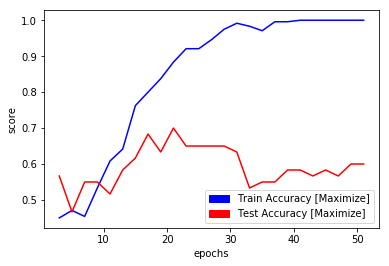

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

# plot the data
x_values = range(display_epoch+1, n_epochs+display_epoch+1, display_epoch)
plt.plot(x_values, acc_train_list, color='blue')
plt.plot(x_values, acc_test_list, color='red')

plt.xlabel('epochs')
plt.ylabel('score');

##### LEARNING RATE EVOLUTION

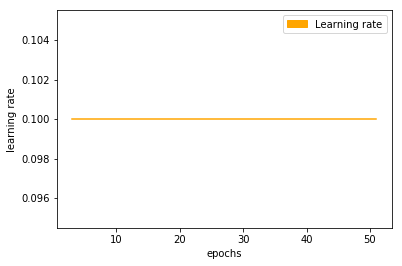

In [20]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(x_values, learning_list, color='orange');
plt.xlabel('epochs'.format(display_epoch))
plt.ylabel('learning rate');